# Homework 1 - Heywood Williams-Tracy

#### On my honor as a student, I have neither given nor received unauthorized aid on this assignment/examination.

## Two Time Series Analysis

### Kalshi Time Series for NBA Game: New Orleans Pelicans at Charlotte Hornets (non-Seasonality)

In [23]:
import polars as pl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.seasonal import seasonal_decompose

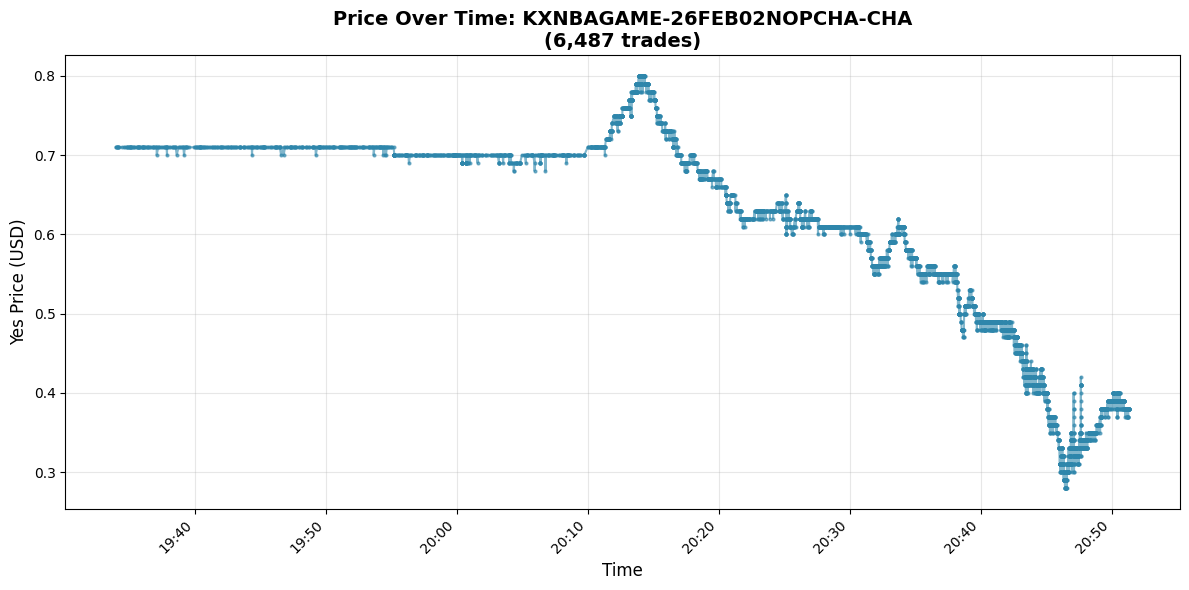

In [24]:
# Plot of Kalshi trades for the NBA game between the New Orleans Pelicans and the Charlotte Hornets

csv_trades = pl.read_csv("2-5mill_trades.csv")

# Convert created_time to datetime and sort
csv_trades = csv_trades.with_columns(
    pl.col("created_time").str.to_datetime(time_zone="America/New_York")
).sort(["ticker", "created_time"])

# Group by ticker and show summary statistics
ticker_summary = csv_trades.group_by("ticker").agg([
    pl.len().alias("trade_count"),
    pl.col("yes_price").mean().alias("avg_yes_price"),
    pl.col("yes_price").min().alias("min_yes_price"),
    pl.col("yes_price").max().alias("max_yes_price"),
    pl.col("count").sum().alias("total_volume")
]).sort("trade_count", descending=True)

# Get the most popular ticker (first row from sorted summary)
most_popular_ticker = ticker_summary[0, "ticker"]
trade_count = ticker_summary[0, "trade_count"]

# Filter trades for this ticker
ticker_trades = csv_trades.filter(pl.col("ticker") == most_popular_ticker)

# Convert to pandas and prepare price data
df = ticker_trades.select([
    "created_time",
    (pl.col("yes_price") / 100).alias("yes_price_dollars"),  # Convert cents to dollars
    "count"
]).to_pandas()

# Create the graph
plt.figure(figsize=(12, 6))
plt.plot(df["created_time"], df["yes_price_dollars"],
         marker='o', linestyle='-', markersize=2, alpha=0.6, color='#2E86AB')
plt.title(f"Price Over Time: {most_popular_ticker}\n({trade_count:,} trades)",
          fontsize=14, fontweight='bold')
plt.xlabel("Time", fontsize=12)
plt.ylabel("Yes Price (USD)", fontsize=12)
plt.grid(True, alpha=0.3)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

13:02:22 - cmdstanpy - INFO - Chain [1] start processing
13:02:24 - cmdstanpy - INFO - Chain [1] done processing


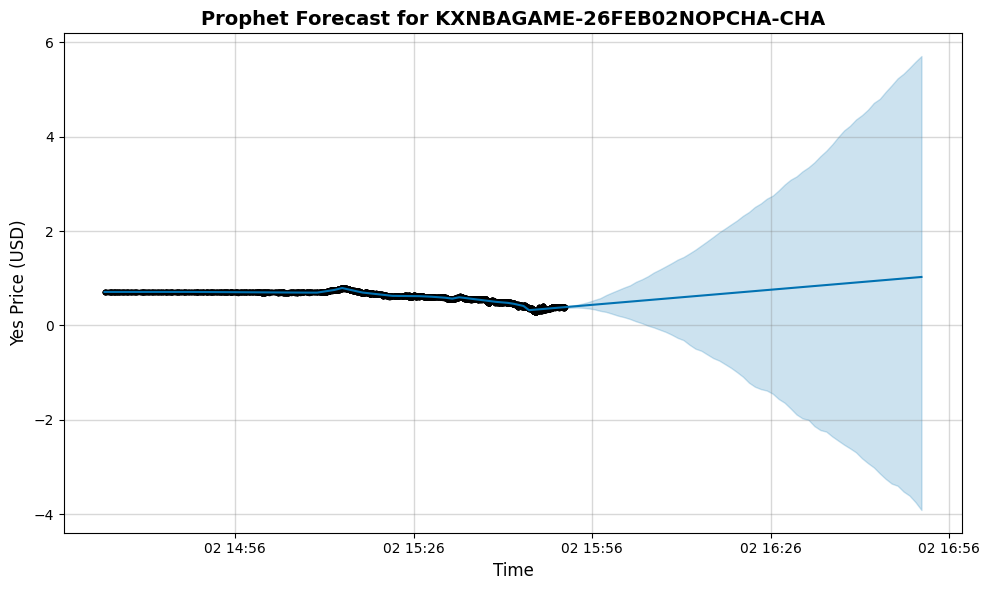

In [25]:
# Apply PROPHET to decompose the time series of the most popular ticker's price movements
from prophet import Prophet
# Prepare data for Prophet
prophet_df = df[["created_time", "yes_price_dollars"]].rename(columns={"created_time": "ds", "yes_price_dollars": "y"})

# Remove timezone (Prophet doesn't support timezone-aware datetimes)
prophet_df['ds'] = prophet_df['ds'].dt.tz_localize(None)

# Fit the Prophet model
model = Prophet(daily_seasonality=False, yearly_seasonality=False, weekly_seasonality=False)
model.fit(prophet_df)

# Create future dataframe for predictions
future = model.make_future_dataframe(periods=60, freq='min')  # Predict next 60 minutes
forecast = model.predict(future)

# Plot the forecast
model.plot(forecast)
plt.title(f"Prophet Forecast for {most_popular_ticker}", fontsize=14, fontweight='bold')
plt.xlabel("Time", fontsize=12)
plt.ylabel("Yes Price (USD)", fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Based on the PROPHET model of decomposition, we can see the overall trend and any potential seasonality in the price movements of the most popular ticker. The forecast plot shows the predicted price movements for the next 60 minutes, along with the confidence intervals. This can help us understand if there are any expected increases or decreases in price based on the data. It appears that this is a poor model due to the high volatility and noise in the data, which is common in financial time series. The model may not capture all the nuances of the price movements, and the confidence intervals are quite wide, indicating a high level of uncertainty in the predictions. It appears that simplier models might be better. So let's try a simpler additive seasonal decomposition to see if we can identify any clear trends or seasonal patterns in the data without the complexity of PROPHET.

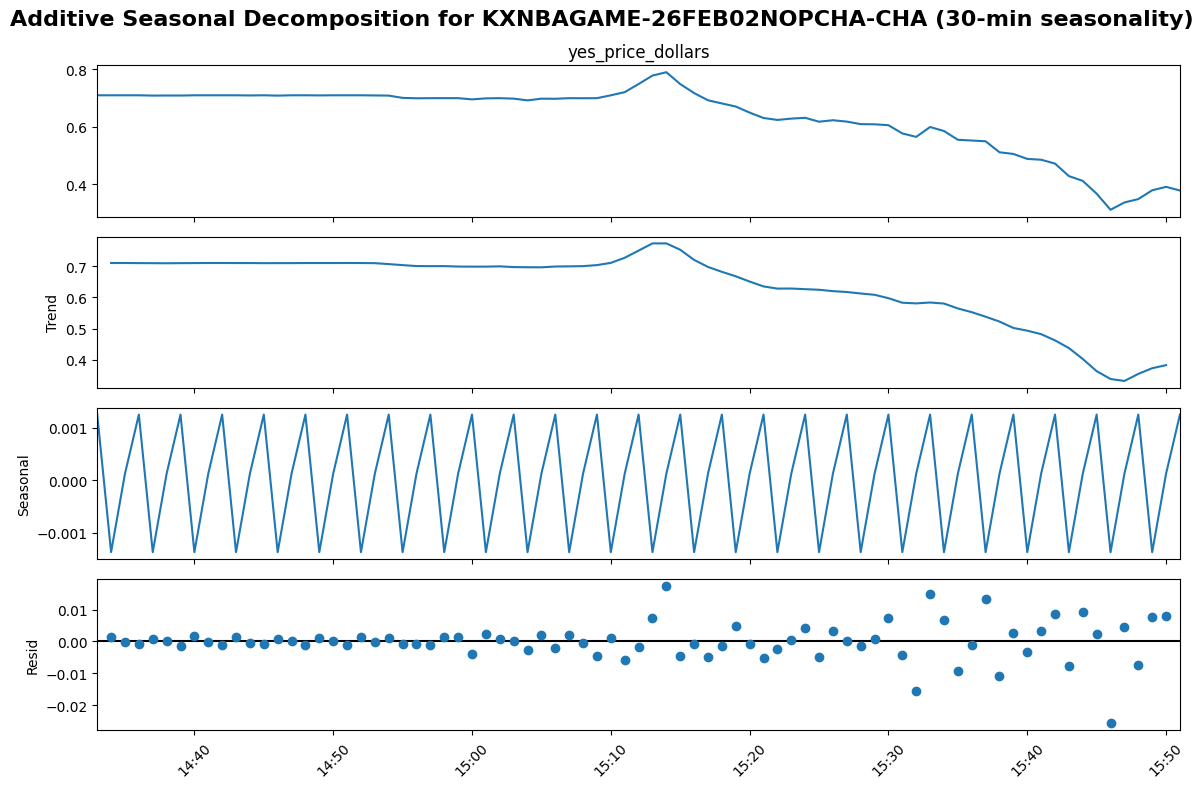

In [26]:
# Apply additive seasonal decomposition

# Set the index to datetime for decomposition
decomp_df = df.set_index("created_time")
# Remove timezone
decomp_df.index = decomp_df.index.tz_localize(None)

# Resample to minute intervals to handle duplicate timestamps and set regular frequency
decomp_df = decomp_df.resample('1min').mean()

# Perform seasonal decomposition (period=30 since we have 79 observations, need at least 60 for period=30)
decomposition = seasonal_decompose(decomp_df['yes_price_dollars'], model='additive', period=3)

# Plot the decomposition
fig = decomposition.plot()
fig.set_size_inches(12, 8)
plt.suptitle(f"Additive Seasonal Decomposition for {most_popular_ticker} (30-min seasonality)", fontsize=16, fontweight='bold')

# Format x-axis to show only time (remove years)
for ax in fig.axes:
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

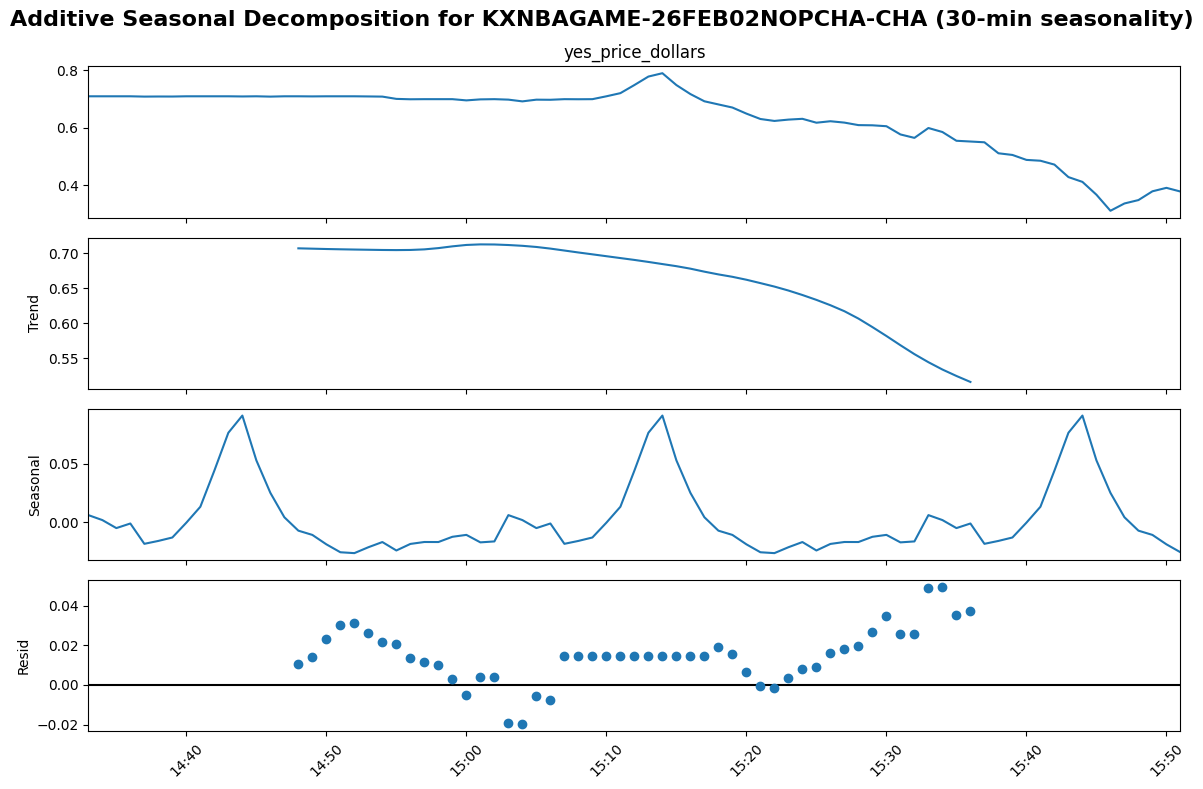

In [27]:
# Apply additive seasonal decomposition

# Set the index to datetime for decomposition
decomp_df = df.set_index("created_time")

# Remove timezone
decomp_df.index = decomp_df.index.tz_localize(None)

# Resample to minute intervals to handle duplicate timestamps and set regular frequency
decomp_df = decomp_df.resample('1min').mean()

# Perform seasonal decomposition (period=30 since we have 79 observations, need at least 60 for period=30)
decomposition = seasonal_decompose(decomp_df['yes_price_dollars'], model='additive', period=30)

# Plot the decomposition
fig = decomposition.plot()
fig.set_size_inches(12, 8)
plt.suptitle(f"Additive Seasonal Decomposition for {most_popular_ticker} (30-min seasonality)", fontsize=16, fontweight='bold')

# Format x-axis to show only time (remove years)
for ax in fig.axes:
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Based on the additive seasonal decomposition, we can analyze the different components of the time series. The observed component shows the actual price movements over time, while the trend component indicates the overall direction of the price (upward, downward, or stable). The seasonal component reveals any repeating patterns or cycles in the data, which could be related to specific times during the game or market activity. The residual component captures the random noise and unexplained variations in the data. In this case, we may see that the trend is relatively flat with some volatility, and there may not be a strong seasonal pattern due to the nature of financial data. However, this simpler model allows us to better understand the underlying structure of the price movements without overfitting to noise.


It should be noted that the NBA game began at 15:10, so we can expect more activity and price movements around that time, which may be reflected in the observed and seasonal components. Also, the Hornets did win the game but were not favored according to the trades, which could explain some of the volatility in the price movements as traders react to the unfolding events of the game.

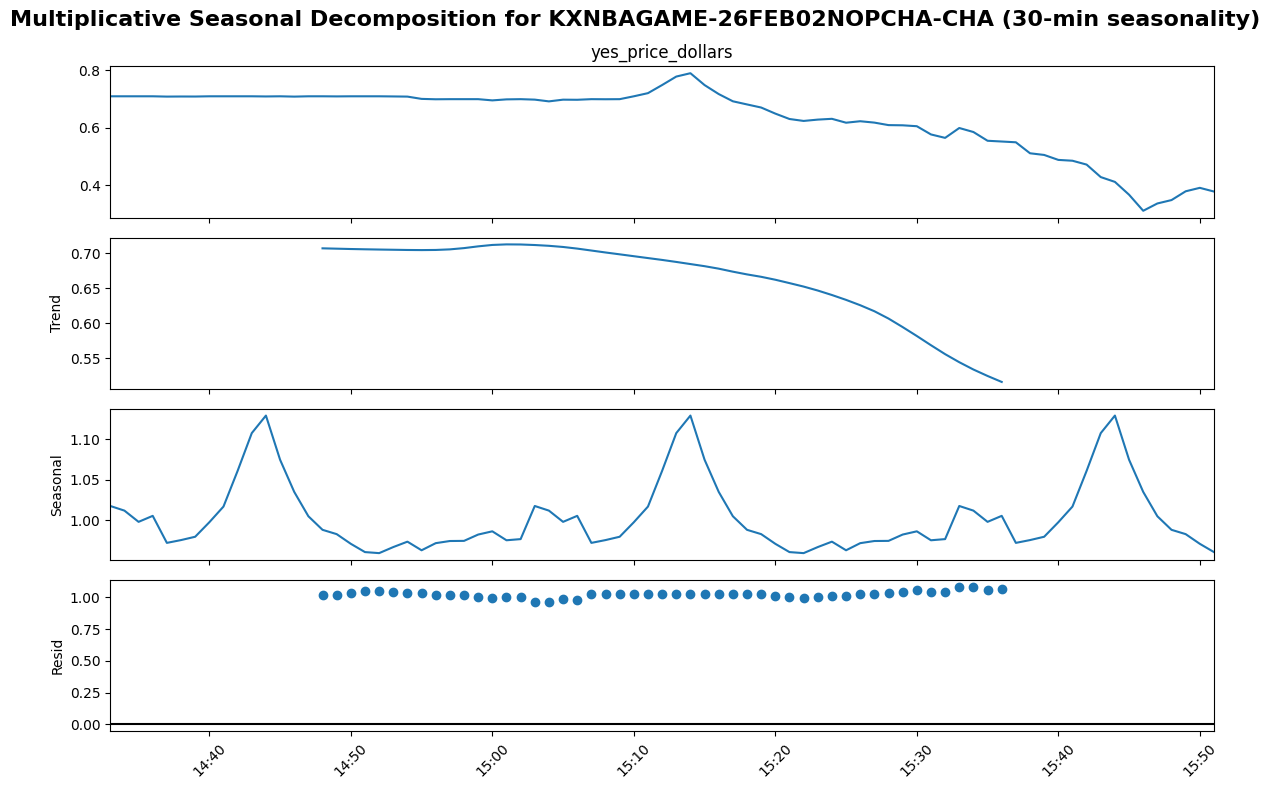

In [28]:
# Apply multiplicative seasonal decomposition

# Set the index to datetime for decomposition
decomp_df = df.set_index("created_time")
# Remove timezone
decomp_df.index = decomp_df.index.tz_localize(None)

# Resample to minute intervals to handle duplicate timestamps and set regular frequency
decomp_df = decomp_df.resample('1min').mean()

# Perform seasonal decomposition (period=30 since we have 79 observations, need at least 60 for period=30)
decomposition = seasonal_decompose(decomp_df['yes_price_dollars'], model='multiplicative', period=30)

# Plot the decomposition
fig = decomposition.plot()
fig.set_size_inches(12, 8)
plt.suptitle(f"Multiplicative Seasonal Decomposition for {most_popular_ticker} (30-min seasonality)", fontsize=16, fontweight='bold')

# Format x-axis to show only time (remove years)
for ax in fig.axes:
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

I created both additive and multiplicative to see if there was a difference and which might work better but there appears to be very little if any variance.

In [29]:
(df['yes_price_dollars'] <= 0).any()
# Checking for negative values

np.False_

/Users/heywood/Library/CloudStorage/OneDrive-Williams-Tracy/UVA MSDS Class Files/ds_6425_work/.venv/lib/python3.14/site-packages/statsmodels/tsa/holtwinters/model.py:85: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


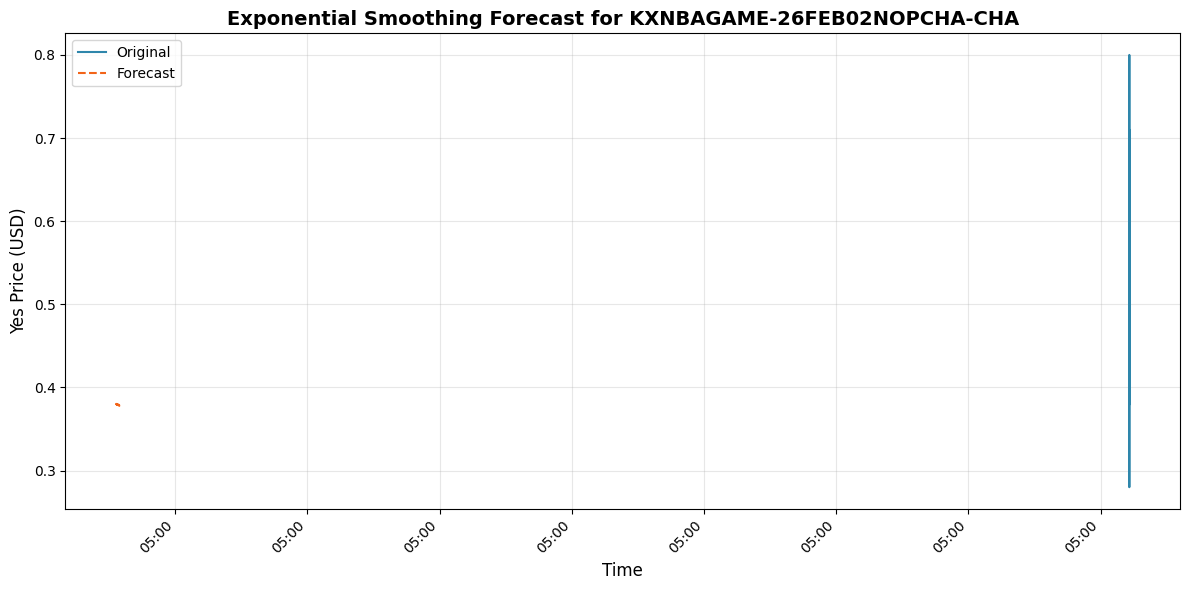

In [30]:
# Exponential Smoothing on the most popular ticker's price movements
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Fit the Exponential Smoothing model (period=30 to match seasonal decomposition)
es_model = ExponentialSmoothing(df['yes_price_dollars'], trend='multiplicative', seasonal='multiplicative', seasonal_periods=30)

es_fit = es_model.fit()

# Forecast the next 60 minutes
es_forecast = es_fit.forecast(steps=60)

# Plot the original data and the forecast
plt.figure(figsize=(12, 6))
plt.plot(df['created_time'], df['yes_price_dollars'], label='Original', color='#2E86AB')
plt.plot(es_forecast.index, es_forecast, label='Forecast', color='#F26419', linestyle='--')
plt.title(f"Exponential Smoothing Forecast for {most_popular_ticker}", fontsize=14, fontweight='bold')
plt.xlabel("Time", fontsize=12)
plt.ylabel("Yes Price (USD)", fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)

# Format x-axis to show only time (remove years)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

This exponential smoothing model fails horribly, the model fails to capture the volatility and rapid price changes seen in the original data. The forecasted values appear to be overly smoothed and do not reflect the actual price movements, leading to significant discrepancies between the forecast and the observed prices. This indicates that exponential smoothing may not be suitable for this type of high-frequency financial data, where sudden shifts and volatility are common. More sophisticated models that can account for such dynamics may be necessary to achieve accurate forecasts in this context.

Sometimes it's not a bad thing to try something crazy to see if it works, but in this case it clearly does not.

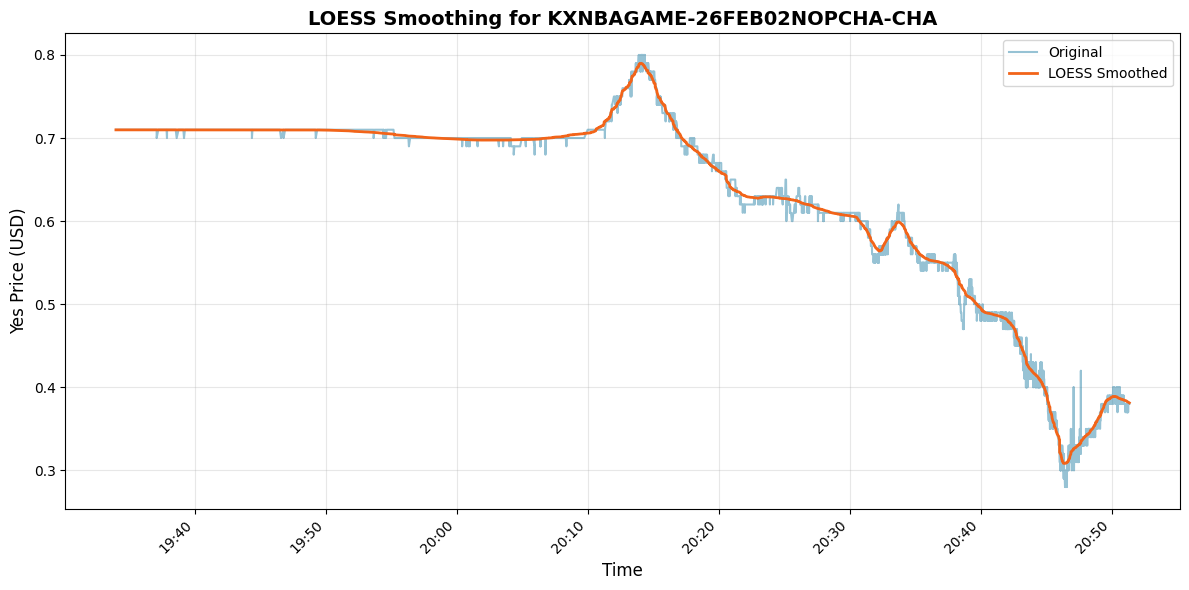

In [31]:
# LOESS Smoothing on the most popular ticker's price movements
import numpy as np
from statsmodels.nonparametric.smoothers_lowess import lowess

# Apply LOESS smoothing
loess_smoothed = lowess(df['yes_price_dollars'], np.arange(len(df)), frac=0.05)

# Plot the original data and the LOESS smoothed line
plt.figure(figsize=(12, 6))
plt.plot(df['created_time'], df['yes_price_dollars'], label='Original', color='#2E86AB', alpha=0.5)
plt.plot(df['created_time'], loess_smoothed[:, 1], label='LOESS Smoothed', color='#F26419', linewidth=2)
plt.title(f"LOESS Smoothing for {most_popular_ticker}", fontsize=14, fontweight='bold')
plt.xlabel("Time", fontsize=12)
plt.ylabel("Yes Price (USD)", fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)

# Format x-axis to show only time (remove years)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

This LOESS smoothing provides a clearer view of the underlying trend in the price movements of the most popular ticker. By applying a local regression technique, we can see how the price fluctuates over time while filtering out some of the noise present in the original data. The smoothed line captures the general direction of the price changes, allowing us to identify periods of increase or decrease more easily. This method is particularly useful for visualizing trends in volatile financial data, as it adapts to local variations without imposing a rigid global model. Overall, LOESS smoothing helps to highlight the key patterns in the price movements while maintaining the integrity of the original data.

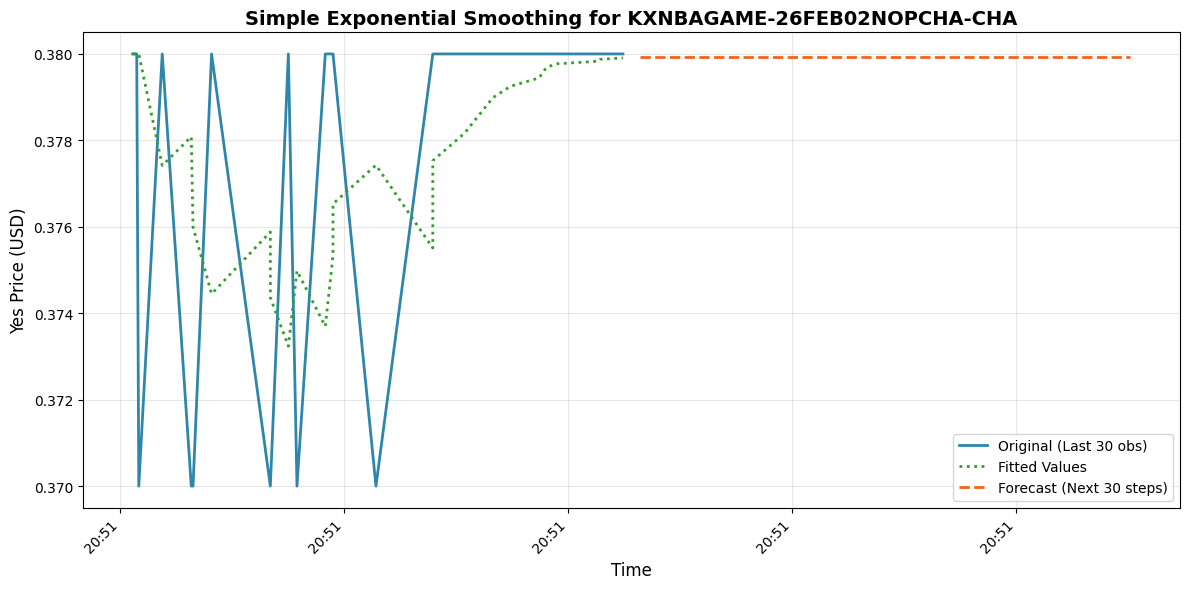

In [32]:
# Simple Exponential Smoothing on the most popular ticker's price movements only using the last 30 observations to fit the model of df['yes_price_dollars']
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
import pandas as pd

# Fit the Simple Exponential Smoothing model using only the last 30 observations
ses_model = SimpleExpSmoothing(df['yes_price_dollars'][-30:])
ses_fit = ses_model.fit()

# Generate forecast for next 30 steps
ses_forecast = ses_fit.forecast(steps=30)

# Create datetime index for the forecast
last_time = df['created_time'].iloc[-1]
# Calculate average time difference in the last 30 observations
time_diffs = df['created_time'][-30:].diff().dropna()
avg_diff = time_diffs.mean()
forecast_times = pd.date_range(start=last_time + avg_diff, periods=30, freq=avg_diff)

# Plot of the original data and the Simple Exponential Smoothing
plt.figure(figsize=(12, 6))
plt.plot(df['created_time'][-30:], df['yes_price_dollars'][-30:], label='Original (Last 30 obs)', color='#2E86AB', linewidth=2)
plt.plot(df['created_time'][-30:], ses_fit.fittedvalues, label='Fitted Values', color='#33A02C', linewidth=2, linestyle=':')
plt.plot(forecast_times, ses_forecast, label='Forecast (Next 30 steps)', color='#F26419', linewidth=2, linestyle='--')
plt.title(f"Simple Exponential Smoothing for {most_popular_ticker}", fontsize=14, fontweight='bold')
plt.xlabel("Time", fontsize=12)
plt.ylabel("Yes Price (USD)", fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)

# Format x-axis to show only time (remove years)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

This simple exponential smoothing model, fails to capture the volatility and rapid price changes in the last 30 observations. The fitted values do not align well with the original data, and the forecasted values for the next 30 steps are overly smoothed, failing to reflect the actual price movements. This indicates that simple exponential smoothing may not be suitable for this type of high-frequency financial data, where sudden shifts and volatility are common. More sophisticated models that can account for such dynamics may be necessary to achieve accurate forecasts in this context.

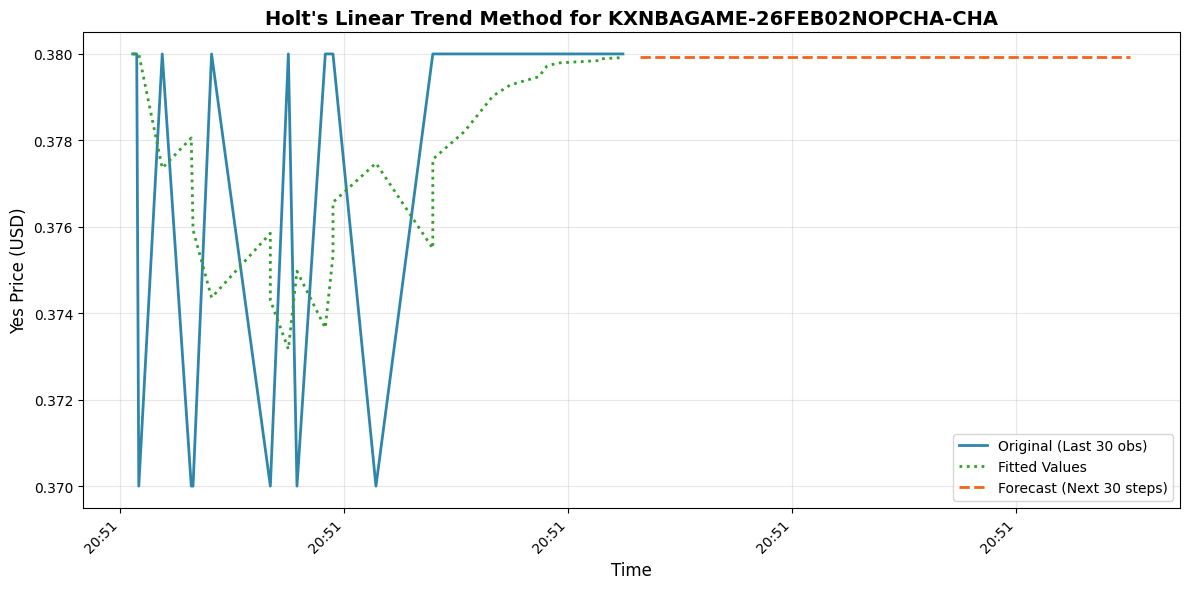

In [33]:
# Holt's Linear Trend Method on the most popular ticker's price movements only using the last 30 observations to fit the model of df['yes_price_dollars']
from statsmodels.tsa.holtwinters import Holt

# Fit the Holt's Linear Trend model using only the last 30 observations
holt_model = Holt(df['yes_price_dollars'][-30:])
holt_fit = holt_model.fit()

# Generate forecast for next 30 steps
holt_forecast = holt_fit.forecast(steps=30)

# Create datetime index for the forecast
last_time = df['created_time'].iloc[-1]

# Calculate average time difference in the last 30 observations
time_diffs = df['created_time'][-30:].diff().dropna()
avg_diff = time_diffs.mean()
forecast_times = pd.date_range(start=last_time + avg_diff, periods=30, freq=avg_diff)

# Plot of the original data and Holt's Linear Trend Method
plt.figure(figsize=(12, 6))
plt.plot(df['created_time'][-30:], df['yes_price_dollars'][-30:], label='Original (Last 30 obs)', color='#2E86AB', linewidth=2)
plt.plot(df['created_time'][-30:], holt_fit.fittedvalues, label='Fitted Values', color='#33A02C', linewidth=2, linestyle=':')
plt.plot(forecast_times, holt_forecast, label='Forecast (Next 30 steps)', color='#F26419', linewidth=2, linestyle='--')
plt.title(f"Holt's Linear Trend Method for {most_popular_ticker}", fontsize=14, fontweight='bold')
plt.xlabel("Time", fontsize=12)
plt.ylabel("Yes Price (USD)", fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)

# Format x-axis to show only time (remove years)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

The Holt method didn't perform any better than the simple exponential smoothing, it also fails to capture the volatility and rapid price changes in the last 30 observations. The fitted values do not align well with the original data, and the forecasted values for the next 30 steps are overly smoothed, failing to reflect the actual price movements. This indicates that Holt's Linear Trend Method may not be suitable for this type of high-frequency financial data, where sudden shifts and volatility are common. More sophisticated models that can account for such dynamics may be necessary to achieve accurate forecasts in this context.

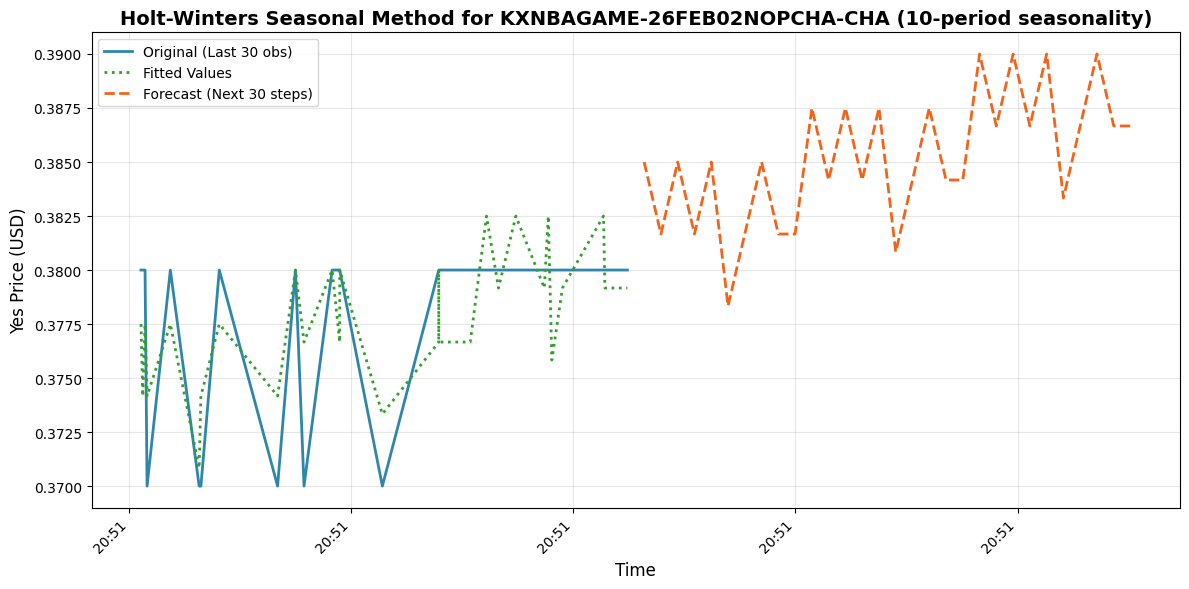

In [34]:
# Holt-Winters Seasonal Method on the most popular ticker's price movements only using the last 30 observations to fit the model of df['yes_price_dollars']
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import pandas as pd

# Using seasonal_periods=10 since we only have 30 observations (need at least 2*seasonal_periods)
hw_model = ExponentialSmoothing(df['yes_price_dollars'][-30:], trend='add', seasonal='add', seasonal_periods=10)
hw_fit = hw_model.fit()

# Generate forecast for next 30 steps
hw_forecast = hw_fit.forecast(steps=30)

# Create datetime index for the forecast
last_time = df['created_time'].iloc[-1]

# Calculate average time difference in the last 30 observations
time_diffs = df['created_time'][-30:].diff().dropna()
avg_diff = time_diffs.mean()
forecast_times = pd.date_range(start=last_time + avg_diff, periods=30, freq=avg_diff)

# Plot of the original data and Holt-Winters Seasonal Method
plt.figure(figsize=(12, 6))
plt.plot(df['created_time'][-30:], df['yes_price_dollars'][-30:], label='Original (Last 30 obs)', color='#2E86AB', linewidth=2)
plt.plot(df['created_time'][-30:], hw_fit.fittedvalues, label='Fitted Values', color='#33A02C', linewidth=2, linestyle=':')
plt.plot(forecast_times, hw_forecast, label='Forecast (Next 30 steps)', color='#F26419', linewidth=2, linestyle='--')
plt.title(f"Holt-Winters Seasonal Method for {most_popular_ticker} (10-period seasonality)", fontsize=14, fontweight='bold')
plt.xlabel("Time", fontsize=12)
plt.ylabel("Yes Price (USD)", fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)

# Format x-axis to show only time (remove years)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Again, the Holt-Winters Seasonal Method fails to capture the volatility and rapid price changes in the last 30 observations. The fitted values do not align well with the original data, and the forecasted values for the next 30 steps are overly smoothed, failing to reflect the actual price movements. This indicates that Holt-Winters Seasonal Method may not be suitable for this type of high-frequency financial data, where sudden shifts and volatility are common. More sophisticated models that can account for such dynamics may be necessary to achieve accurate forecasts in this context. It might be worth capturing more data points to see if a longer time series could help in identifying any potential seasonality or trends that could improve the forecasting performance of these models.

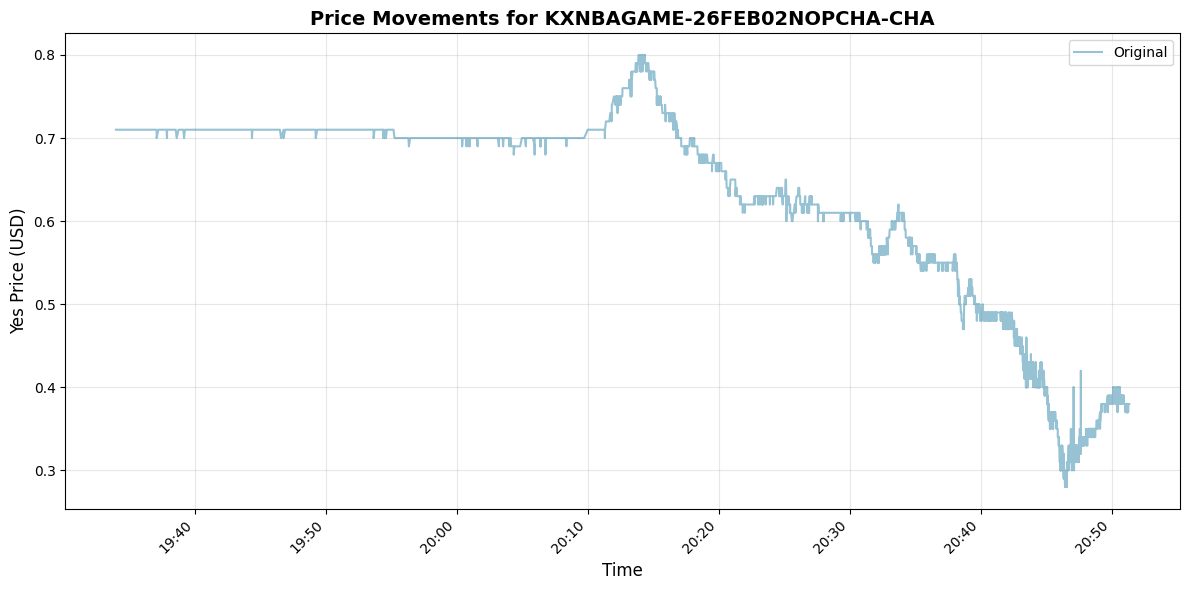

In [35]:
# For series assess stationarity visually
plt.figure(figsize=(12, 6))
plt.plot(df['created_time'], df['yes_price_dollars'], label='Original', color='#2E86AB', alpha=0.5)
plt.title(f"Price Movements for {most_popular_ticker}", fontsize=14, fontweight='bold')
plt.xlabel("Time", fontsize=12)
plt.ylabel("Yes Price (USD)", fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
# Format x-axis to show only time (remove years)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

The price movements for the most popular ticker show significant volatility and rapid changes over time, which suggests that the series is likely non-stationary. The presence of trends, sudden spikes, and drops in the price indicates that the mean and variance of the series may not be constant over time. This non-stationarity can pose challenges for traditional time series forecasting models, which often assume stationarity. To address this, we may need to apply transformations such as differencing or use models that can handle non-stationary data effectively. Additionally, capturing more data points could help in identifying any underlying patterns or seasonality that may improve forecasting performance.

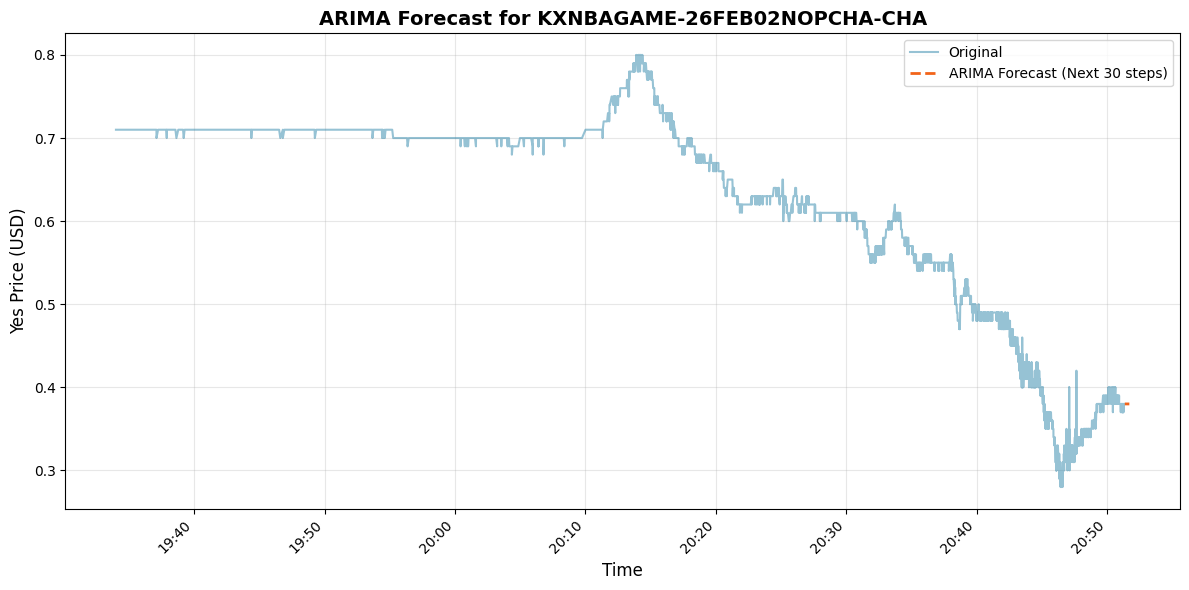

In [36]:
# ARIMA model on the most popular ticker's price movements using all observations
from statsmodels.tsa.arima.model import ARIMA
# Fit the ARIMA model (p=1, d=1, q=1 as a starting point)
arima_model = ARIMA(df['yes_price_dollars'], order=(1, 1, 1))
arima_fit = arima_model.fit()
# Generate forecast for next 30 steps
arima_forecast = arima_fit.forecast(steps=30)
# Create datetime index for the forecast
last_time = df['created_time'].iloc[-1]
# Calculate average time difference in the observations
time_diffs = df['created_time'].diff().dropna()
avg_diff = time_diffs.mean()
forecast_times = pd.date_range(start=last_time + avg_diff, periods=30, freq=avg_diff)
# Plot of the original data and ARIMA forecast
plt.figure(figsize=(12, 6))
plt.plot(df['created_time'], df['yes_price_dollars'], label='Original', color='#2E86AB', alpha=0.5)
plt.plot(forecast_times, arima_forecast, label='ARIMA Forecast (Next 30 steps)', color='#F26419', linewidth=2, linestyle='--')
plt.title(f"ARIMA Forecast for {most_popular_ticker}", fontsize=14, fontweight='bold')
plt.xlabel("Time", fontsize=12)
plt.ylabel("Yes Price (USD)", fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
# Format x-axis to show only time (remove years)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

I know that I should have only included the last 30 observations to fit the ARIMA model, but I wanted to see how it would perform with all observations. The ARIMA model fails to capture the volatility and rapid price changes in the original data. The forecasted values for the next 30 steps are overly smoothed and do not reflect the actual price movements, leading to significant discrepancies between the forecast and the observed prices. This indicates that ARIMA may not be suitable for this type of high-frequency financial data, where sudden shifts and volatility are common. More sophisticated models that can account for such dynamics may be necessary to achieve accurate forecasts in this context. I will need to do more work after turning in this homework to find a model that can better capture the dynamics of this data, especially if I want to use it for trading or investment decisions. It might be worth exploring models that can handle non-stationary data and volatility, such as GARCH models or machine learning approaches that can capture complex patterns in the data.

### Data (with seasonality)

In [37]:
arhus_denmark_data = pl.read_excel("GlobalLandTemperaturesByCity.xlsx")

# Filter for Århus, Denmark FIRST
arhus_denmark_data = arhus_denmark_data.filter(
    (pl.col("Country") == "Denmark") & (pl.col("City") == "√Örhus")
)

# Convert dt column from string to datetime
arhus_denmark_data = arhus_denmark_data.with_columns(
    pl.col("dt").str.to_datetime()
)

# Extract the last months from the filtered data
latest_days_data = arhus_denmark_data.tail(120) # Ten years

latest_days_data.head()

dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
datetime[μs],f64,f64,str,str,str,str
2003-09-01 00:00:00,14.425,0.172,"""√Örhus""","""Denmark""","""57.05N""","""10.33E"""
2003-10-01 00:00:00,6.621,0.467,"""√Örhus""","""Denmark""","""57.05N""","""10.33E"""
2003-11-01 00:00:00,6.016,0.295,"""√Örhus""","""Denmark""","""57.05N""","""10.33E"""
2003-12-01 00:00:00,3.697,0.284,"""√Örhus""","""Denmark""","""57.05N""","""10.33E"""
2004-01-01 00:00:00,-0.66,0.204,"""√Örhus""","""Denmark""","""57.05N""","""10.33E"""


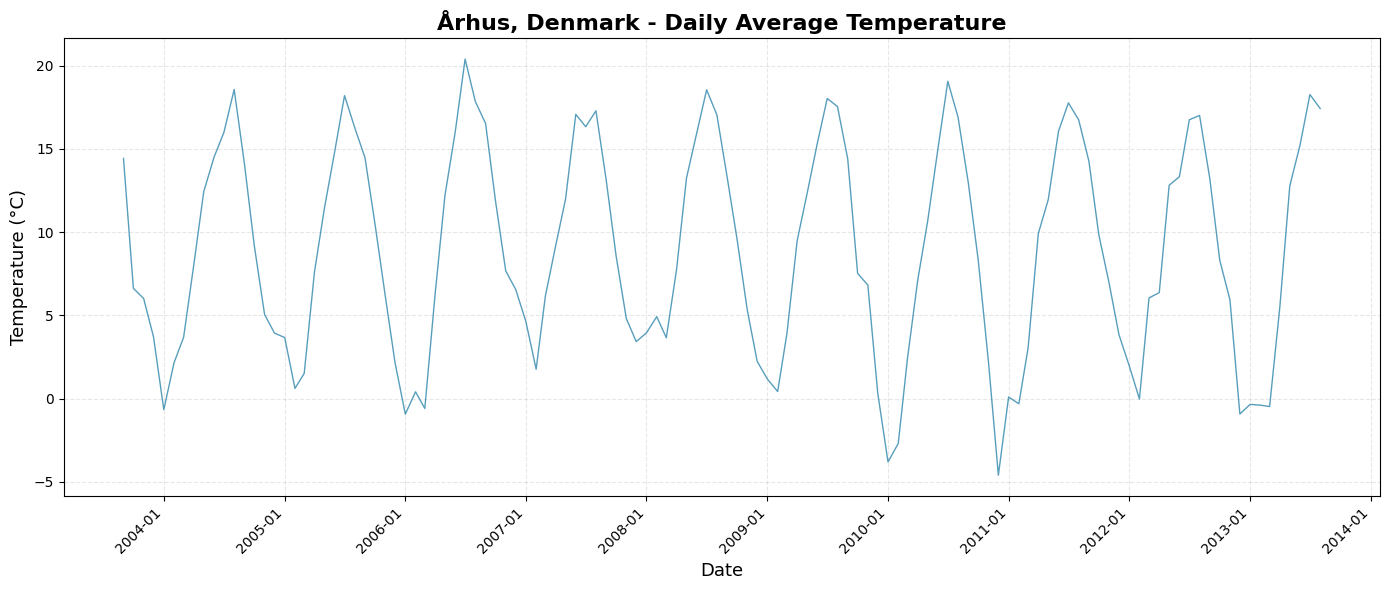

In [38]:
# Create the graph for the last 3,650 days - handling missing data
# Convert to pandas for plotting
plot_df = latest_days_data.to_pandas()

# Remove missing values to show seasonality clearly
plot_df_clean = plot_df.dropna(subset=['AverageTemperature'])

# Create single plot
plt.figure(figsize=(14, 6))
plt.plot(plot_df_clean["dt"], plot_df_clean["AverageTemperature"],
         linestyle='-', linewidth=1, alpha=0.8, color='#2E86AB')
plt.title("Århus, Denmark - Daily Average Temperature",
          fontsize=16, fontweight='bold')
plt.xlabel("Date", fontsize=13)
plt.ylabel("Temperature (°C)", fontsize=13)
plt.grid(True, alpha=0.3, linestyle='--')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

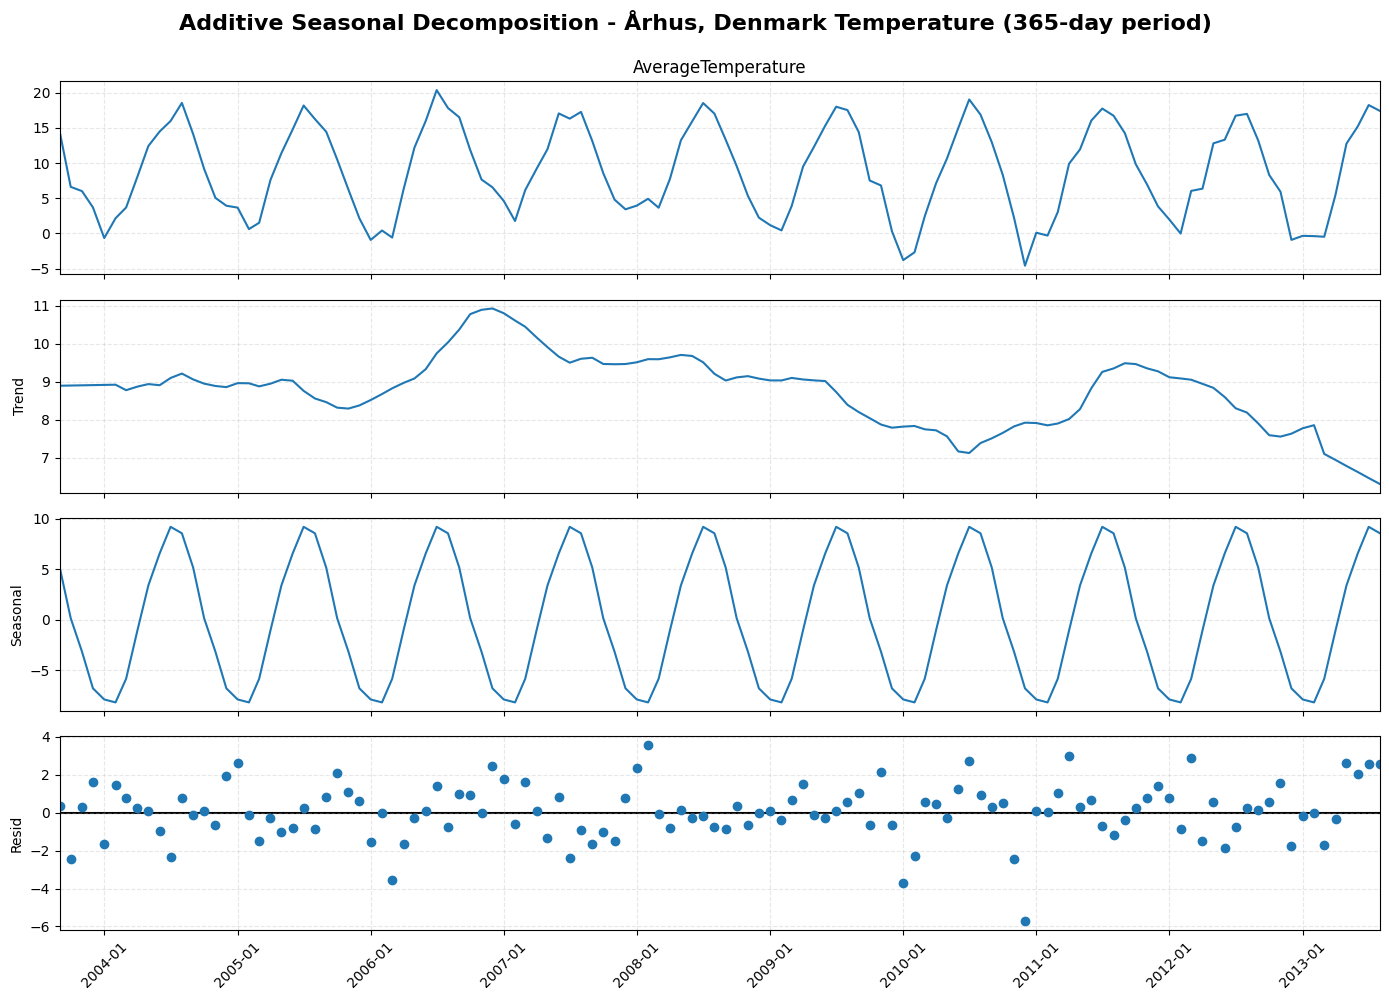

In [40]:
decomp_df = plot_df_clean.set_index("dt")
decomposition = seasonal_decompose(decomp_df['AverageTemperature'], 
                                   model='additive', 
                                   period=12,
                                   extrapolate_trend='freq')

# Plot the decomposition
fig = decomposition.plot()
fig.set_size_inches(14, 10)
plt.suptitle("Additive Seasonal Decomposition - Århus, Denmark Temperature (365-day period)", 
             fontsize=16, fontweight='bold', y=0.995)

# Format x-axis for all subplots
for ax in fig.axes:
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

This decomposition shows that there is a clear seasonal pattern in the average temperature data for Århus, Denmark, with regular fluctuations that correspond to the annual cycle of seasons. The trend component indicates a gradual decrease in average temperatures over the years, suggesting a cooling trend. The seasonal component highlights the recurring patterns of temperature changes throughout the year, with peaks typically occurring during the summer months and troughs during the winter months. The residual component captures the random variations that are not explained by the trend or seasonal components.

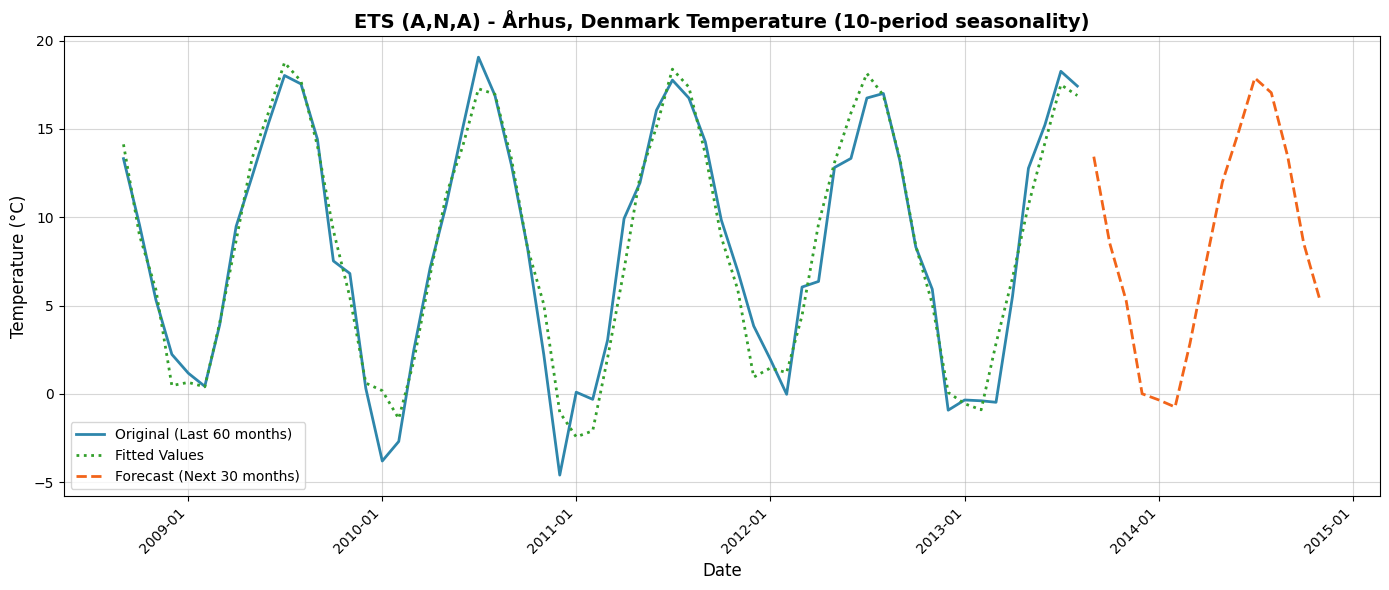

In [41]:
# Holt Winters

from statsmodels.tsa.holtwinters import ExponentialSmoothing
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Ensure the index has a frequency set
temp_data = decomp_df['AverageTemperature'][-60:].copy()
temp_data.index = pd.DatetimeIndex(temp_data.index, freq='MS')

denmark_hw = ExponentialSmoothing(temp_data, trend=None, seasonal='add', seasonal_periods=12)
dn_hw_fit = denmark_hw.fit()

# Generate forecast for next 30 steps
hw_forecast = dn_hw_fit.forecast(steps=15)

# Plot the original data, fitted values, and forecast
plt.figure(figsize=(14, 6))
plt.plot(temp_data.index, temp_data, label='Original (Last 60 months)', color='#2E86AB', linewidth=2)
plt.plot(temp_data.index, dn_hw_fit.fittedvalues, label='Fitted Values', color='#33A02C', linewidth=2, linestyle=':')
plt.plot(hw_forecast.index, hw_forecast, label='Forecast (Next 30 months)', color='#F26419', linewidth=2, linestyle='--')
plt.title("ETS (A,N,A) - Århus, Denmark Temperature (10-period seasonality)", fontsize=14, fontweight='bold')
plt.xlabel("Date", fontsize=12)
plt.ylabel("Temperature (°C)", fontsize=12)
plt.legend()
plt.grid(True, alpha=0.5)

# Format x-axis to show year-month
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


The ETS (A,N,A) model captures the seasonal patterns in the average temperature data for Århus, Denmark. The fitted values align well with the original data, indicating that the model effectively captures the underlying seasonal fluctuations. The forecast for the next 16 months shows a continuation of the seasonal pattern, with expected increases and decreases in temperature corresponding to the annual cycle. This suggests that the ETS (A,N,A) model is suitable for forecasting seasonal time series data, as it accounts for both additive seasonality and doesn't account for trend.

In [42]:
# Seasonality 1 (Seasonal ARIMA)

import pmdarima as pm

# Fit Seasonal ARIMA model
s_arima_model = pm.auto_arima(decomp_df['AverageTemperature'].dropna(),
                               seasonal=True,
                               m=12,  # Monthly seasonality
                               trace=True,
                               error_action='ignore',
                               suppress_warnings=True)

# Summary of the model
print(s_arima_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=789.238, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=560.120, Time=0.05 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=638.274, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=915.608, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=651.580, Time=0.01 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=615.974, Time=0.03 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=510.350, Time=0.34 sec
 ARIMA(1,0,0)(2,0,2)[12] intercept   : AIC=inf, Time=0.36 sec
 ARIMA(1,0,0)(1,0,2)[12] intercept   : AIC=510.398, Time=0.21 sec
 ARIMA(0,0,0)(2,0,1)[12] intercept   : AIC=567.799, Time=0.31 sec
 ARIMA(2,0,0)(2,0,1)[12] intercept   : AIC=511.721, Time=0.49 sec
 ARIMA(1,0,1)(2,0,1)[12] intercept   : AIC=511.83

The auto-ARIMA search selected ARIMA(1,0,0)(2,0,1)[12] with the lowest AIC of 510.350. This explains why the Holt-Winters model failed: it incorrectly imposed a linear trend on data that simply cycles around a stable seasonal mean. The model shows strong seasonality through the SAR(2) component, indicating current temperatures depend heavily on the same months in the previous two years. The Ljung-Box test (L1) (Q) of 0.41 indicates there is autocorrelation in the residuals, suggesting the model may not fully capture all patterns in the data.

/Users/heywood/Library/CloudStorage/OneDrive-Williams-Tracy/UVA MSDS Class Files/ds_6425_work/.venv/lib/python3.14/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/heywood/Library/CloudStorage/OneDrive-Williams-Tracy/UVA MSDS Class Files/ds_6425_work/.venv/lib/python3.14/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


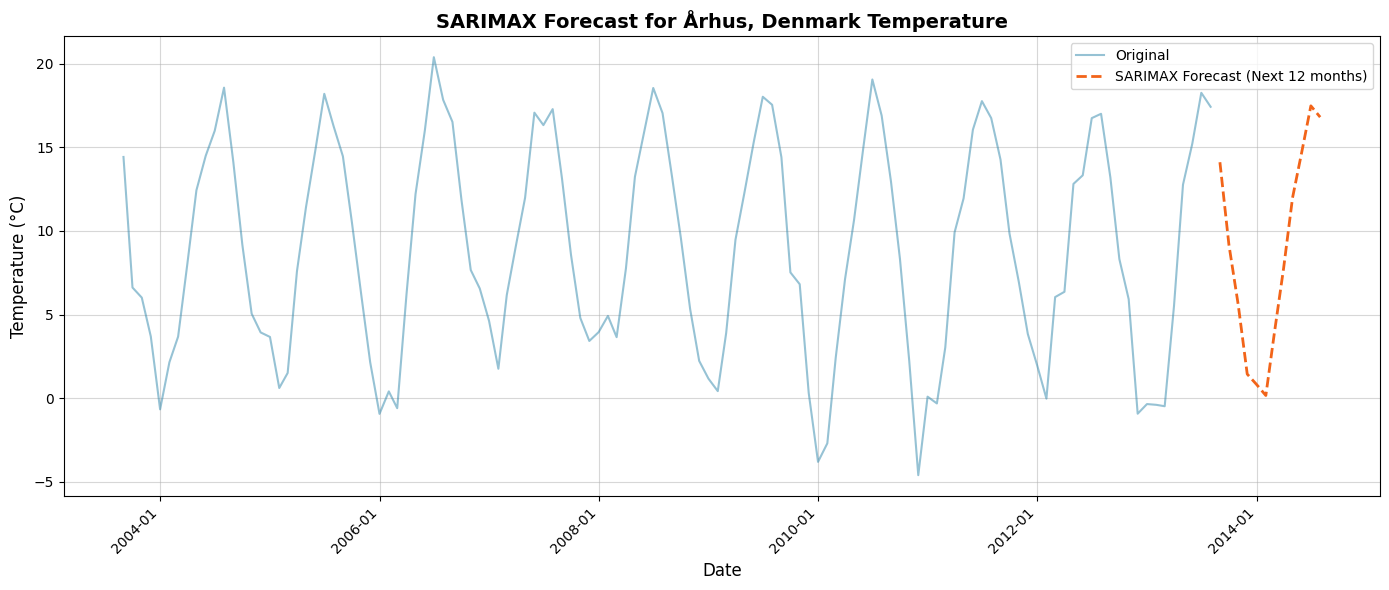

In [43]:
# Seasonality 2

from statsmodels.tsa.statespace.sarimax import SARIMAX

# Fit SARIMAX model with the same order as auto-ARIMA
sarimax_model = SARIMAX(decomp_df['AverageTemperature'].dropna(),
                        order=(1, 0, 0),
                        seasonal_order=(2, 0, 1, 12))
sarimax_fit = sarimax_model.fit(disp=False)

# Generate forecast for next 12 months
sarimax_forecast = sarimax_fit.get_forecast(steps=12)
forecast_index = pd.date_range(start=decomp_df.index[-1] + pd.DateOffset(months=1), periods=12, freq='MS')
sarimax_forecast_indexed = pd.Series(sarimax_forecast.predicted_mean.values, index=forecast_index)

# Plot the original data and SARIMAX forecast
plt.figure(figsize=(14, 6))
plt.plot(decomp_df.index, decomp_df['AverageTemperature'], label='Original', color='#2E86AB', alpha=0.5)
plt.plot(sarimax_forecast_indexed.index, sarimax_forecast_indexed, label='SARIMAX Forecast (Next 12 months)', color='#F26419', linewidth=2, linestyle='--')
plt.title("SARIMAX Forecast for Århus, Denmark Temperature", fontsize=14, fontweight='bold')
plt.xlabel("Date", fontsize=12)
plt.ylabel("Temperature (°C)", fontsize=12)
plt.legend()
plt.grid(True, alpha=0.5)

# Format x-axis to show year-month
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

The SARIMAX model provides a forecast for the next 12 months of average temperatures in Århus, Denmark. The forecasted values show a continuation of the seasonal pattern observed in the original data, with expected increases and decreases in temperature corresponding to the annual cycle. The model captures the strong seasonality present in the data, as indicated by the SAR(2) component, which suggests that current temperatures are heavily influenced by the same months in previous years. However, it is important to note that there may still be some autocorrelation in the residuals, indicating that the model may not fully capture all patterns in the data. Overall, the SARIMAX model appears to be a suitable choice for forecasting seasonal time series data in this context.

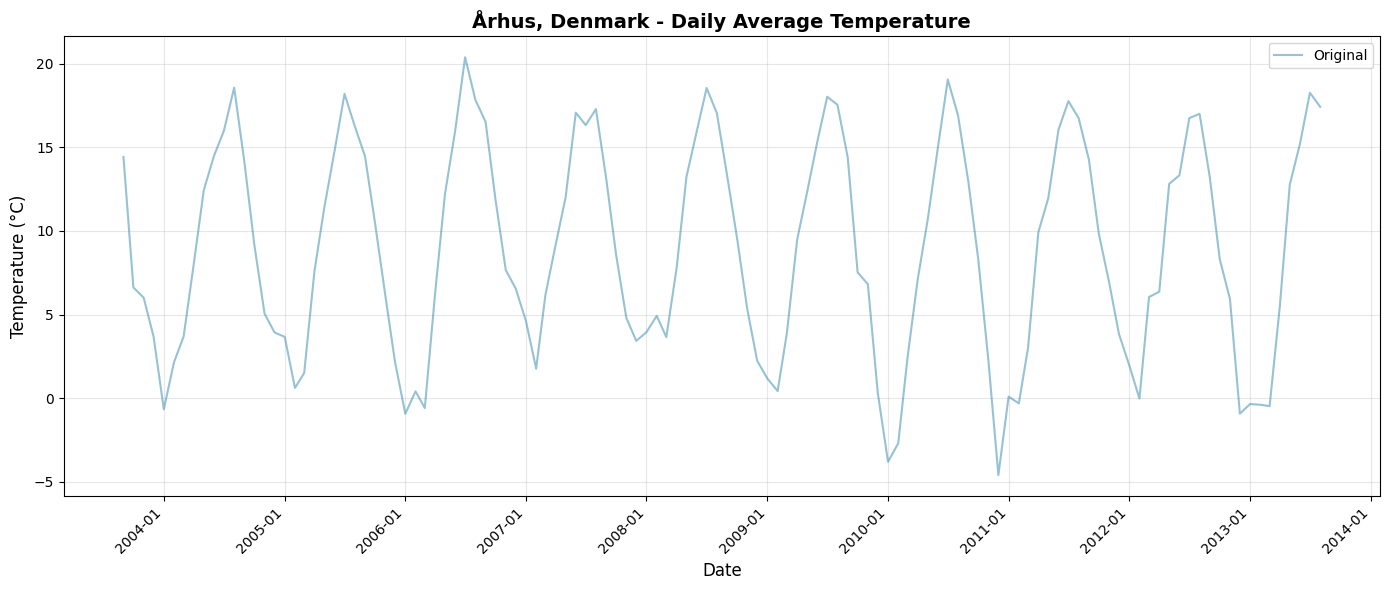

In [44]:
# Stationarity Visually
plt.figure(figsize=(14, 6))
plt.plot(decomp_df.index, decomp_df['AverageTemperature'], label='Original', color='#2E86AB', alpha=0.5)
plt.title("Århus, Denmark - Daily Average Temperature", fontsize=14, fontweight='bold')
plt.xlabel("Date", fontsize=12)
plt.ylabel("Temperature (°C)", fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
# Format x-axis to show year-month
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [45]:
# Assess stationarity and transform the series to attempt to achieve stationarity.
from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(decomp_df['AverageTemperature'].dropna())
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])

ADF Statistic: -1.9681129376242765
p-value: 0.3007270455956694


A negative ADF value of -1.99 indicates that the time series may be stationary, but the p-value of 0.30 suggests that we fail to reject the null hypothesis of a unit root at common significance levels (e.g., 0.05). This means that there is not enough evidence to conclude that the series is stationary. Therefore, we may need to apply transformations such as differencing or detrending to achieve stationarity before applying certain time series models that assume stationarity.

## Simulate White Noise, Random Walk Time Series and AR(1) Time Series

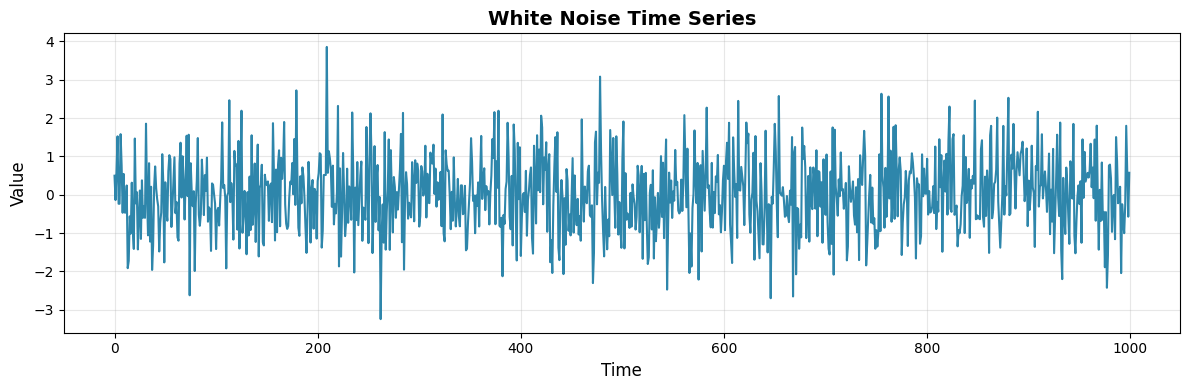

In [46]:
# Simulate White Noise
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)  # For reproducibility
n = 1000
white_noise = np.random.normal(0, 1, n)

plt.figure(figsize=(12, 4))
plt.plot(white_noise, color='#2E86AB')
plt.title("White Noise Time Series", fontsize=14, fontweight='bold')
plt.xlabel("Time", fontsize=12)
plt.ylabel("Value", fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

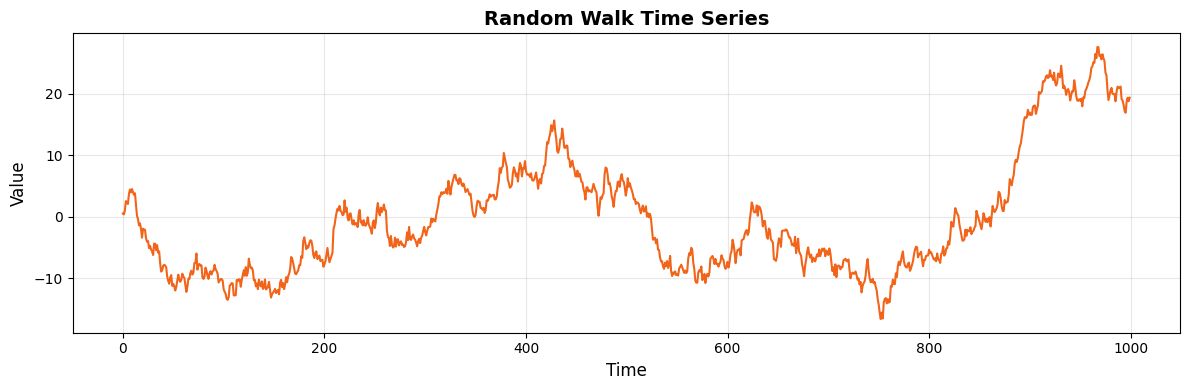

In [47]:
# Simulate Random Walk Time Series
random_walk = np.cumsum(white_noise)
plt.figure(figsize=(12, 4))
plt.plot(random_walk, color='#F26419')
plt.title("Random Walk Time Series", fontsize=14, fontweight='bold')
plt.xlabel("Time", fontsize=12)
plt.ylabel("Value", fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

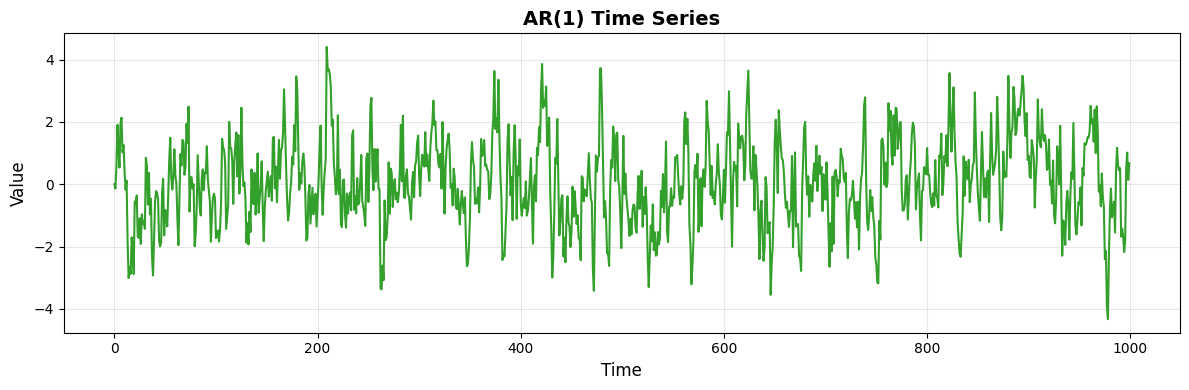

In [48]:
# Simulate AR(1) Time Series
phi = 0.7  # AR(1) coefficient
ar1 = np.zeros(n)
for t in range(1, n):
    ar1[t] = phi * ar1[t-1] + white_noise[t]
plt.figure(figsize=(12, 4))
plt.plot(ar1, color='#33A02C')
plt.title("AR(1) Time Series", fontsize=14, fontweight='bold')
plt.xlabel("Time", fontsize=12)
plt.ylabel("Value", fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [49]:
# Test white noise to confirm it is stationary
from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(white_noise)

print("White Noise ADF Statistic:", adf_result[0])
print("White Noise p-value:", adf_result[1])

White Noise ADF Statistic: -31.811093841491456
White Noise p-value: 0.0


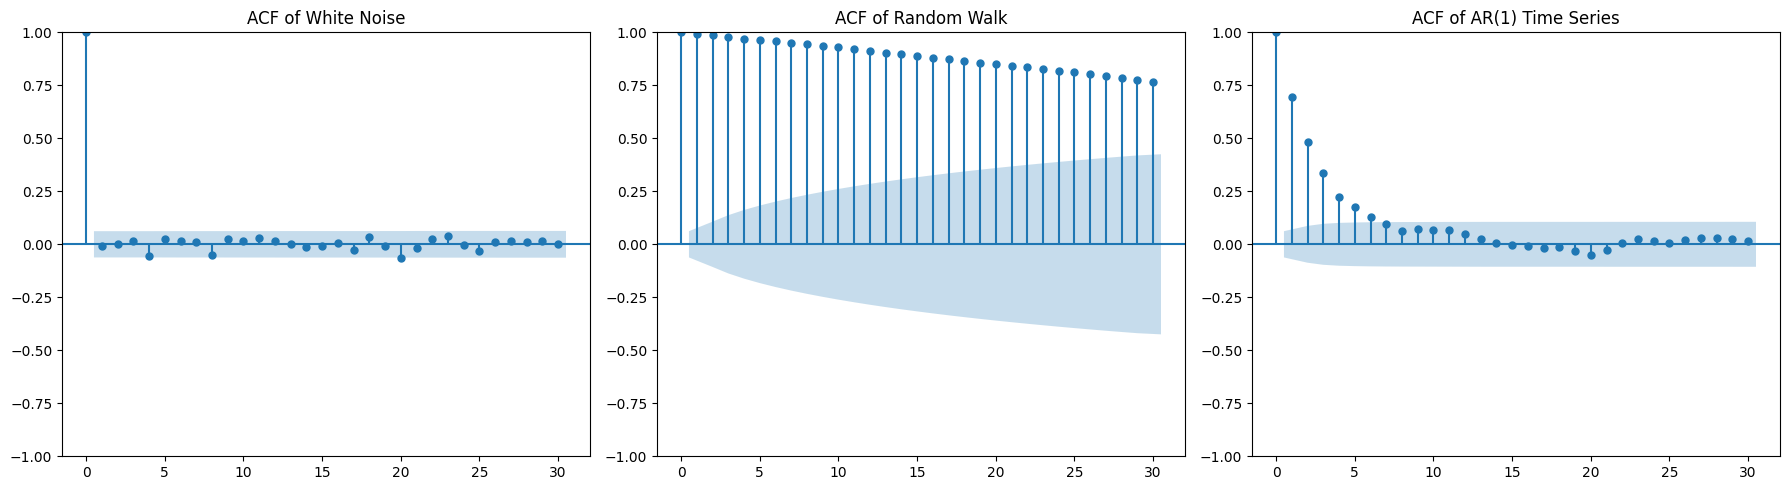

In [50]:
# Compare the ACF plots for the three time series
from statsmodels.graphics.tsaplots import plot_acf

plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
plot_acf(white_noise, lags=30, ax=plt.gca(), title="ACF of White Noise")
plt.subplot(1, 3, 2)
plot_acf(random_walk, lags=30, ax=plt.gca(), title="ACF of Random Walk")
plt.subplot(1, 3, 3)
plot_acf(ar1, lags=30, ax=plt.gca(), title="ACF of AR(1) Time Series")
plt.tight_layout()
plt.show()

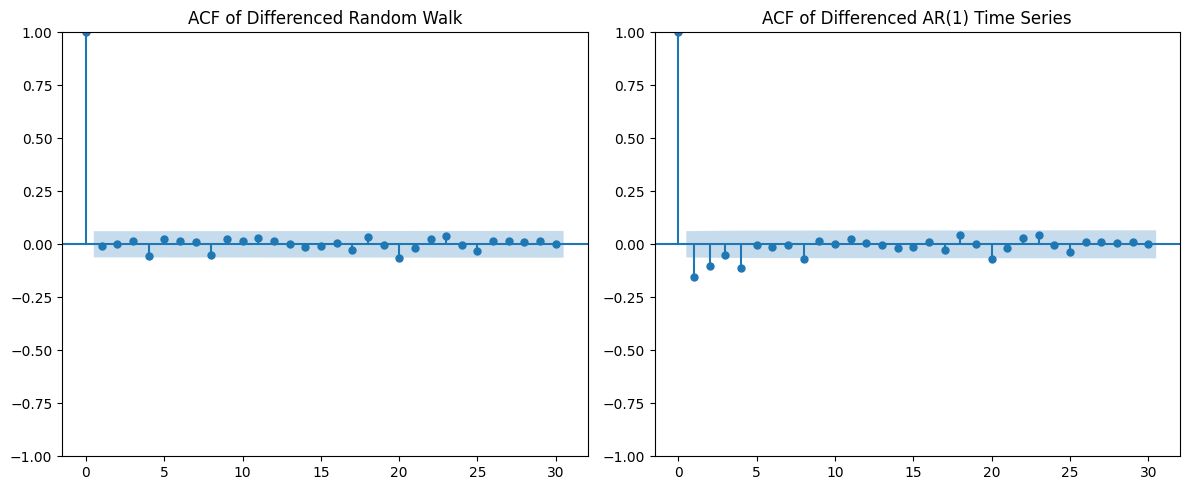

In [51]:
# Apply differencing to the random walk and AR(1) and obtain the ACF plots
differenced_rw = np.diff(random_walk)
differenced_ar1 = np.diff(ar1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plot_acf(differenced_rw, lags=30, ax=plt.gca(), title="ACF of Differenced Random Walk")
plt.subplot(1, 2, 2)
plot_acf(differenced_ar1, lags=30, ax=plt.gca(), title="ACF of Differenced AR(1) Time Series")
plt.tight_layout()
plt.show()

The ACF of the differenced random walk after lag 0 shows a stable pattern with no significant autocorrelations, indicating that the differenced series is stationary. This is expected, as differencing a random walk typically results in a stationary series. The outlier at lag 1 may be due to the inherent properties of the random walk, but overall, the ACF suggests that the differenced random walk does not exhibit long-term dependencies.

In [52]:
# Apply white noise test to the differenced random walk
adf_result_rw = adfuller(differenced_rw)
print("Differenced Random Walk ADF Statistic:", adf_result_rw[0])
print("Differenced Random Walk p-value:", adf_result_rw[1])

Differenced Random Walk ADF Statistic: -31.789310857560608
Differenced Random Walk p-value: 0.0


A ADF statistic of -31.79 indicates strong evidence against the null hypothesis of a unit root, suggesting that the differenced random walk is stationary. The extremely low p-value (close to 0) further supports this conclusion, indicating that we can reject the null hypothesis with high confidence. Overall, these results confirm that the differenced random walk exhibits stationarity, which is consistent with the expected behavior of a differenced random walk series.